In [102]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [104]:
MONTH = 21
YEAR = 12 * MONTH

In [105]:
START = '2013-01-01'
END = '2017-12-31'

In [106]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [107]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [108]:
DATA_STORE = '/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5'

In [109]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [110]:
# Remove stocks with few observations
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [111]:
# Align price and meta data
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [112]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [113]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2168898 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2168784 non-null  float64
 1   close   2168898 non-null  float64
 2   low     2168898 non-null  float64
 3   high    2168898 non-null  float64
 4   volume  2168898 non-null  float64
dtypes: float64(5)
memory usage: 91.8+ MB


In [114]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   marketcap  1758 non-null   object
 1   ipoyear    803 non-null    object
 2   sector     1758 non-null   object
dtypes: object(3)
memory usage: 54.9+ KB


In [115]:
stocks.sector.value_counts()

sector
consumer_discretionary    422
finance                   324
industrials               252
technology                205
health_care               194
real_estate               112
utilities                  72
energy                     68
consumer_staples           53
telecommunications         25
basic_materials            24
miscellaneous               7
Name: count, dtype: int64

In [116]:
# Optional: persist intermediate results:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [117]:
# Optional: persist intermediate results:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

In [118]:
# Compute Rolling Average Dollar Volume
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)
# print((prices.dollar_vol.index.levels[0]))
# print(prices.index.get_level_values('date'))

In [119]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21, on=prices.dollar_vol.index.levels[0])
                           .mean()).values

In [120]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2168898 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2168784 non-null  float64
 1   close          2168898 non-null  float64
 2   low            2168898 non-null  float64
 3   high           2168898 non-null  float64
 4   volume         2168898 non-null  float64
 5   dollar_vol     2168898 non-null  float64
 6   dollar_vol_1m  2133738 non-null  float64
dtypes: float64(7)
memory usage: 124.9+ MB


In [121]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [122]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2168898 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2168784 non-null  float64
 1   close            2168898 non-null  float64
 2   low              2168898 non-null  float64
 3   high             2168898 non-null  float64
 4   volume           2168898 non-null  float64
 5   dollar_vol       2168898 non-null  float64
 6   dollar_vol_1m    2133738 non-null  float64
 7   dollar_vol_rank  2133738 non-null  float64
dtypes: float64(8)
memory usage: 141.4+ MB


In [131]:
prices['rsi'] = prices.groupby(level='ticker', group_keys=False).close.apply(RSI)

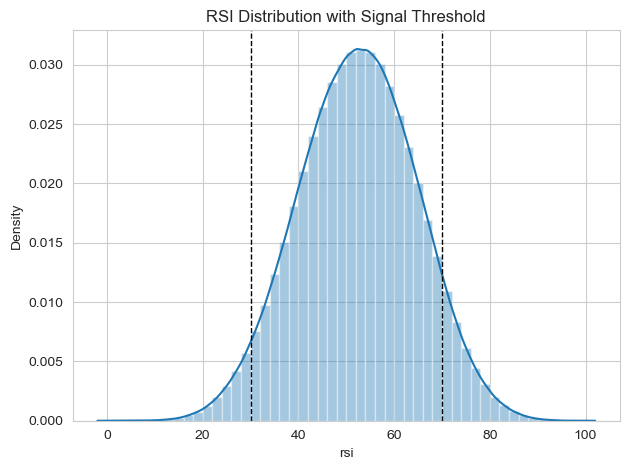

In [132]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

In [133]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [135]:
prices = (prices.join(prices
                      .groupby(level='ticker', group_keys=False)
                      .close
                      .apply(compute_bb)))

In [136]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

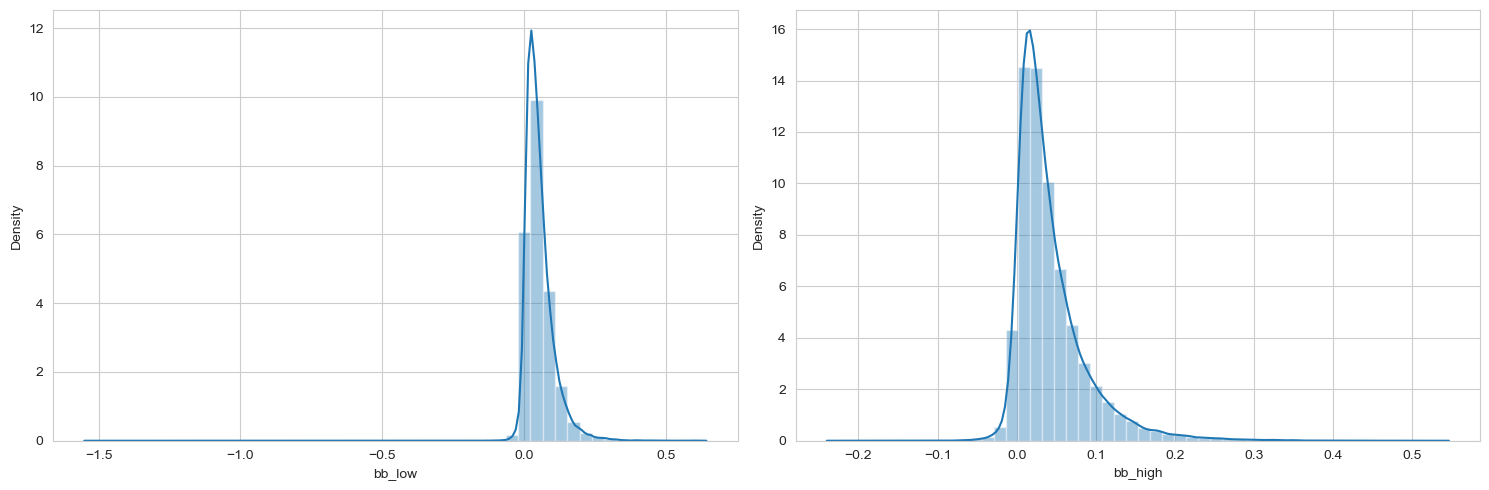

In [137]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

In [138]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [139]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

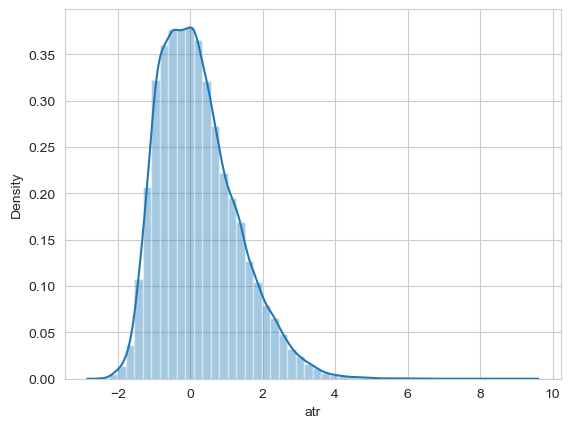

In [140]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

In [141]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [142]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [143]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')


count    2,110,884.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.0
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

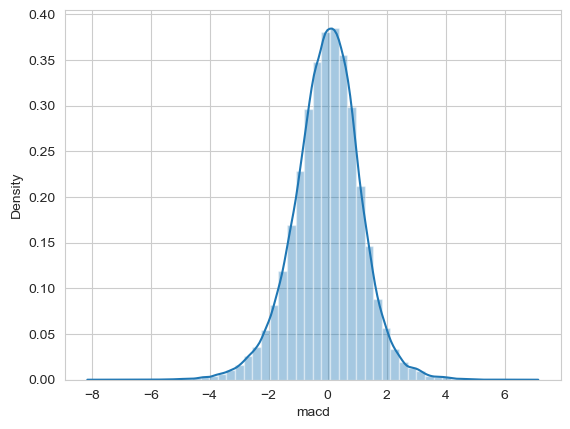

In [144]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

In [145]:
lags = [1, 5, 10, 21, 42, 63]

In [146]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,3.13%
min,-87.57%
0.01%,-30.66%
0.1%,-13.64%
1%,-6.00%
50%,0.05%
99%,6.40%
99.9%,15.61%
99.99%,34.37%
max,"2,588.17%"


In [147]:
q = 0.0001

In [148]:
# Winsorize outliers - after calculating the return for the past lag days and then deriving return for 1 period.
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [149]:
# Shift lagged returns (shifting, the above calculated returns, forward by t*lag here).
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

In [150]:
# Compute forward returns (and set them as target by shifting the prices, calculated 2 steps earlier, behind 
# by 1, 5, 10 & 21 days). These values then become the model target for time t0.
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [151]:
# Combine Price and Meta Data 
prices = prices.join(stocks[['sector']])

In [152]:
# Create time and sector dummy variables
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [154]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2168898 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2168784 non-null  float64
 1   close            2168898 non-null  float64
 2   low              2168898 non-null  float64
 3   high             2168898 non-null  float64
 4   volume           2168898 non-null  float64
 5   dollar_vol       2168898 non-null  float64
 6   dollar_vol_1m    2133738 non-null  float64
 7   dollar_vol_rank  2133738 non-null  float64
 8   rsi              2144286 non-null  float64
 9   bb_high          2135496 non-null  float64
 10  bb_low           2135480 non-null  float64
 11  atr              2144286 non-null  float64
 12  macd             2110884 non-null  float64
 13  return_1d        2167140 non-null  float64
 14  return_5d        2160108 non-null  float6

In [156]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'model_data/no_dummies')

In [157]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [158]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2168898 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   open                    2168784 non-null  float64
 1   close                   2168898 non-null  float64
 2   low                     2168898 non-null  float64
 3   high                    2168898 non-null  float64
 4   volume                  2168898 non-null  float64
 5   dollar_vol              2168898 non-null  float64
 6   dollar_vol_1m           2133738 non-null  float64
 7   dollar_vol_rank         2133738 non-null  float64
 8   rsi                     2144286 non-null  float64
 9   bb_high                 2135496 non-null  float64
 10  bb_low                  2135480 non-null  float64
 11  atr                     2144286 non-null  float64
 12  macd                    2110884 non-nul

In [159]:
# Store model data
prices.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'model_data')

In [170]:
# Explore Data
# Plot Factors
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

In [161]:
# RSI
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [162]:

top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4007.0,0.001319,0.009936,-0.054536,-0.003305,0.001167,0.006212,0.046050
"(30, 70]",107357.0,0.000463,0.007454,-0.150028,-0.003016,0.000649,0.004226,0.073075
"(70, 100]",10713.0,0.000115,0.006289,-0.087857,-0.002725,0.000203,0.003160,0.058570


-2.43% (0.00%)


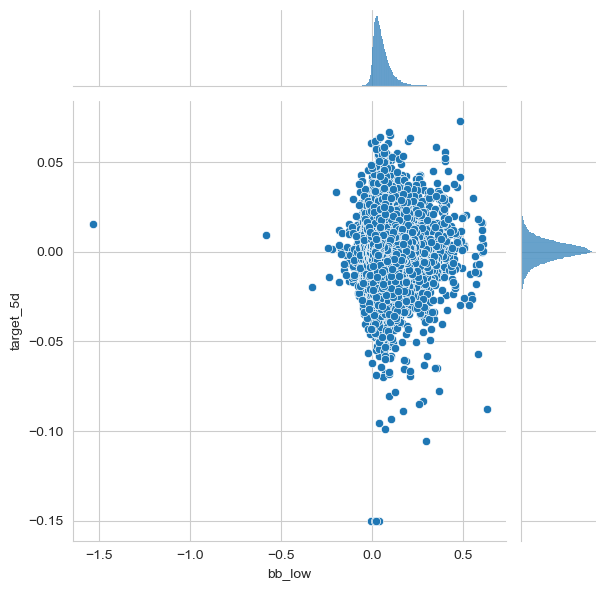

In [163]:
# Bollinger Bands
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

4.37% (0.00%)


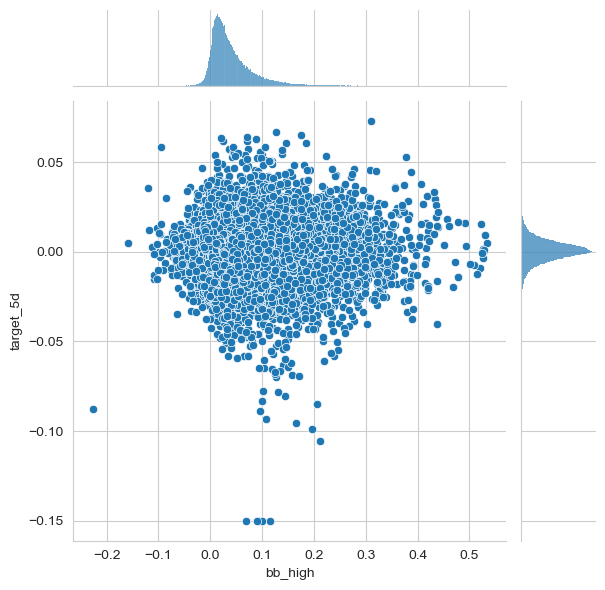

In [164]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-0.13% (65.65%)


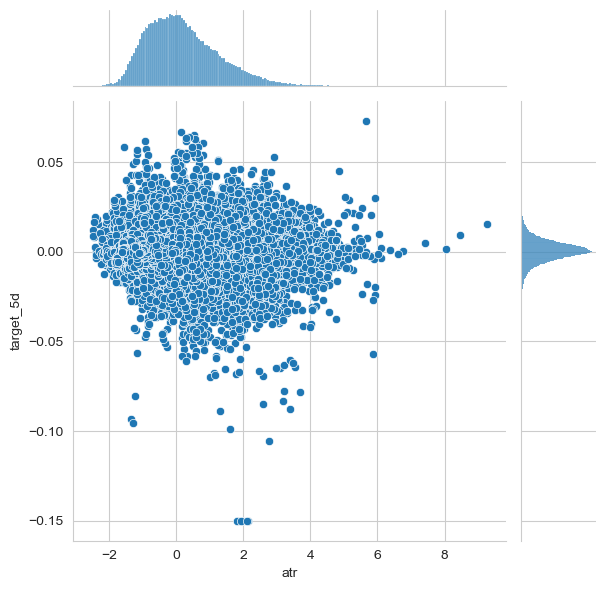

In [165]:
# ATR
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-4.76% (0.00%)


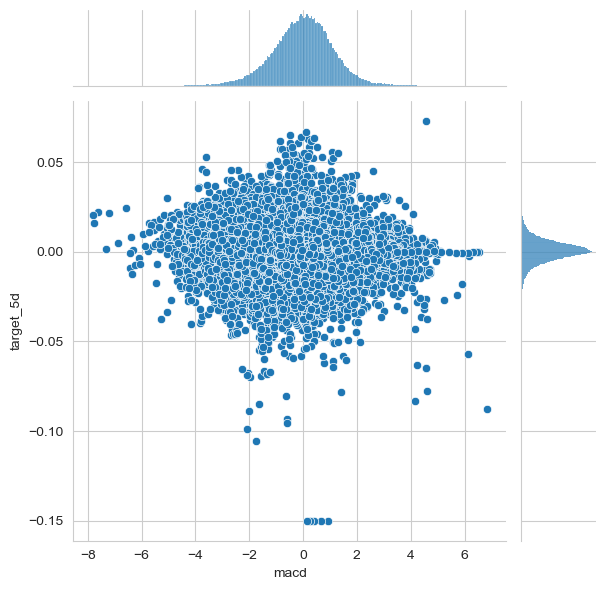

In [166]:
# MACD
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')